In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("/home/rbusche/projects/incense/")

In [4]:
ids = [12, 13, 14, 15, 16, 17, 18, 19, 20]

In [14]:
len(ids)

9

In [5]:
from incense import FileSystemExperimentLoader
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

In [6]:
RUNS_DIR = "/home/rbusche/runs/"
loader = FileSystemExperimentLoader(RUNS_DIR)

In [10]:
exp = loader.find_by_id(12)
exp

FileSystemExperiment(id=12, name=configs/cohort_18_paper/kde_elu/kde_elu_seed_01)

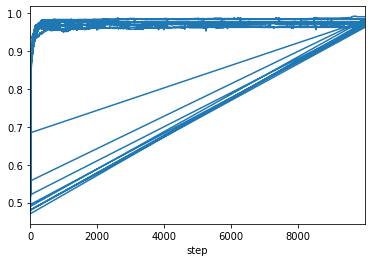

In [9]:
exp.metrics["test.accuracy"].plot()

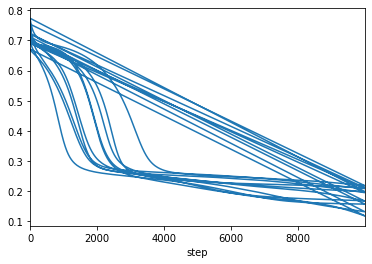

In [18]:
exp.metrics["test.loss"].plot()

## activation function = relu, estimator = mi_estimator.binning

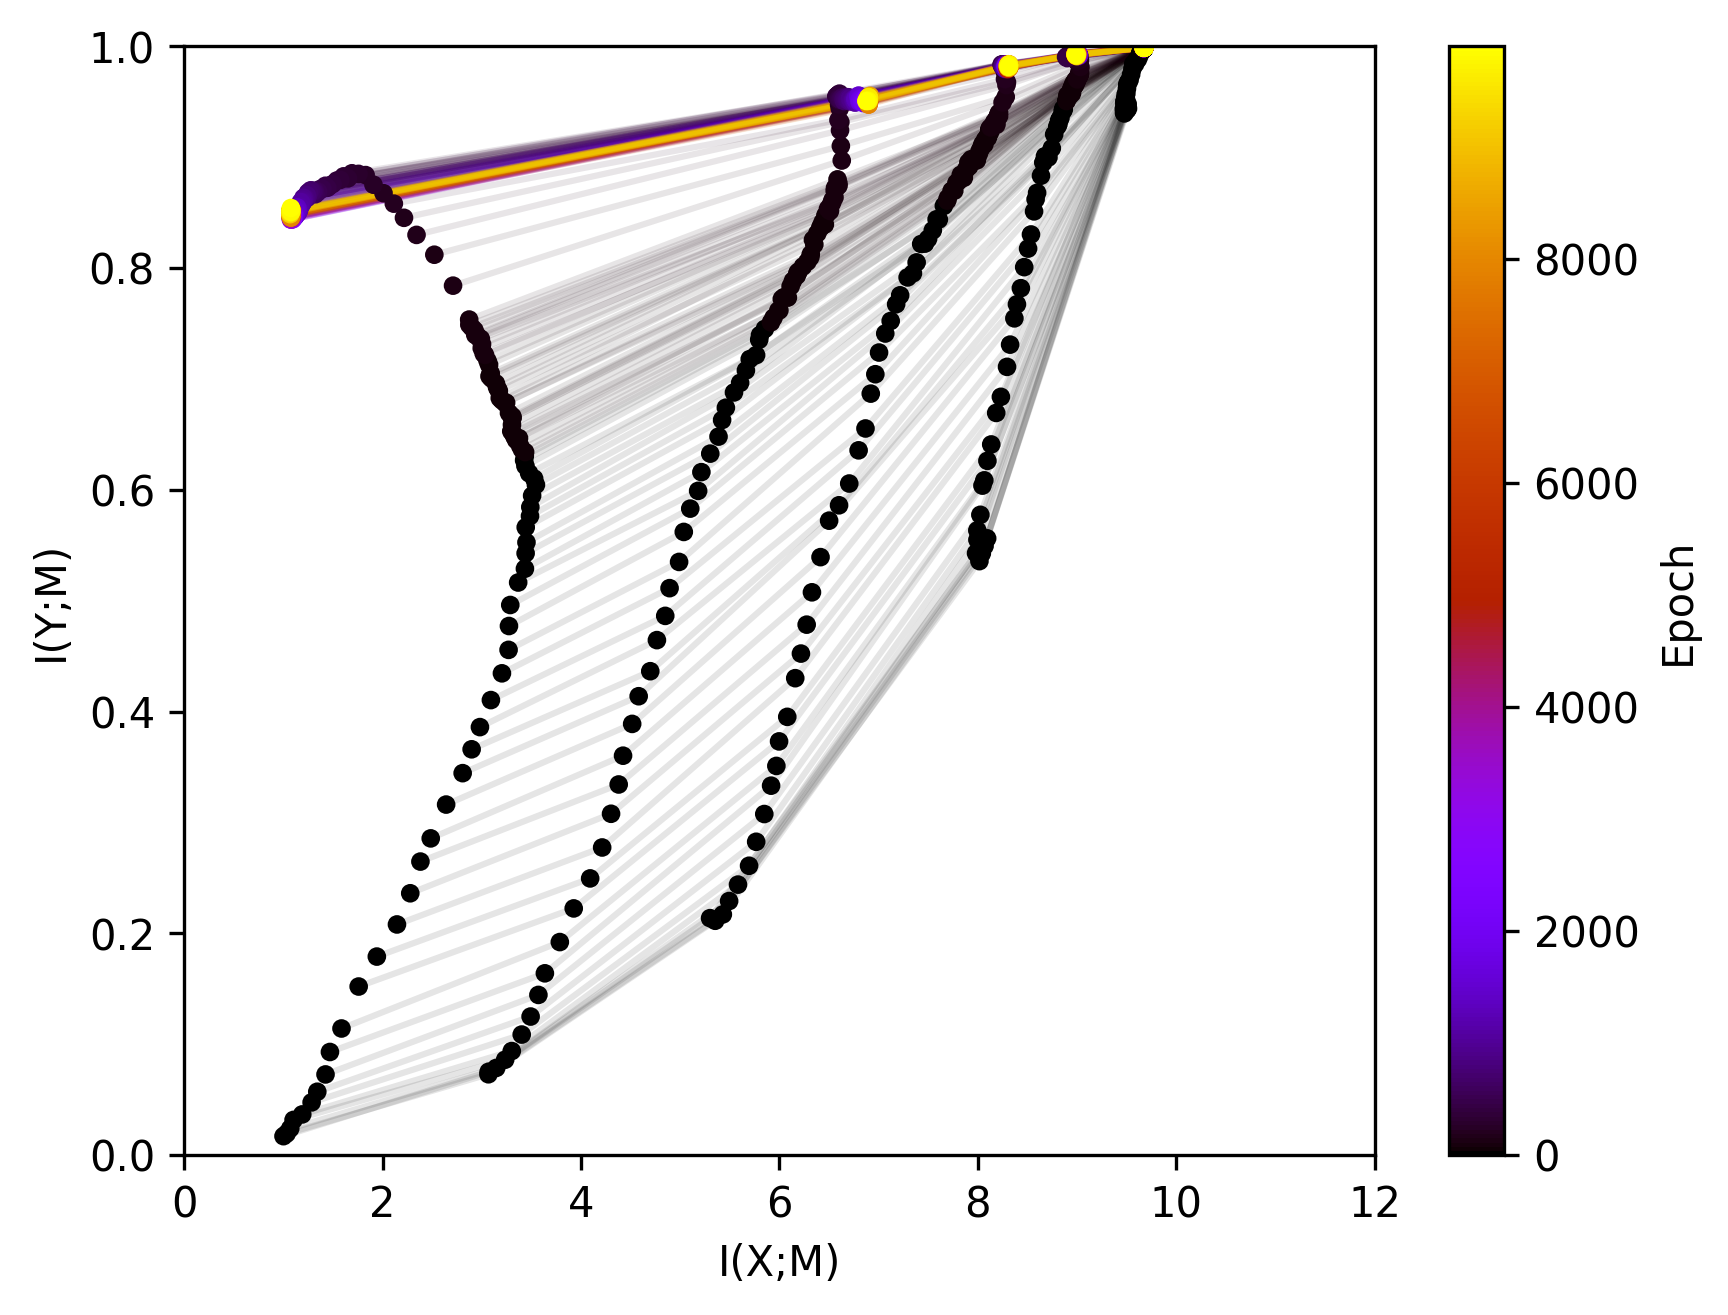

## activation function = elu, estimator = mi_estimator.upper

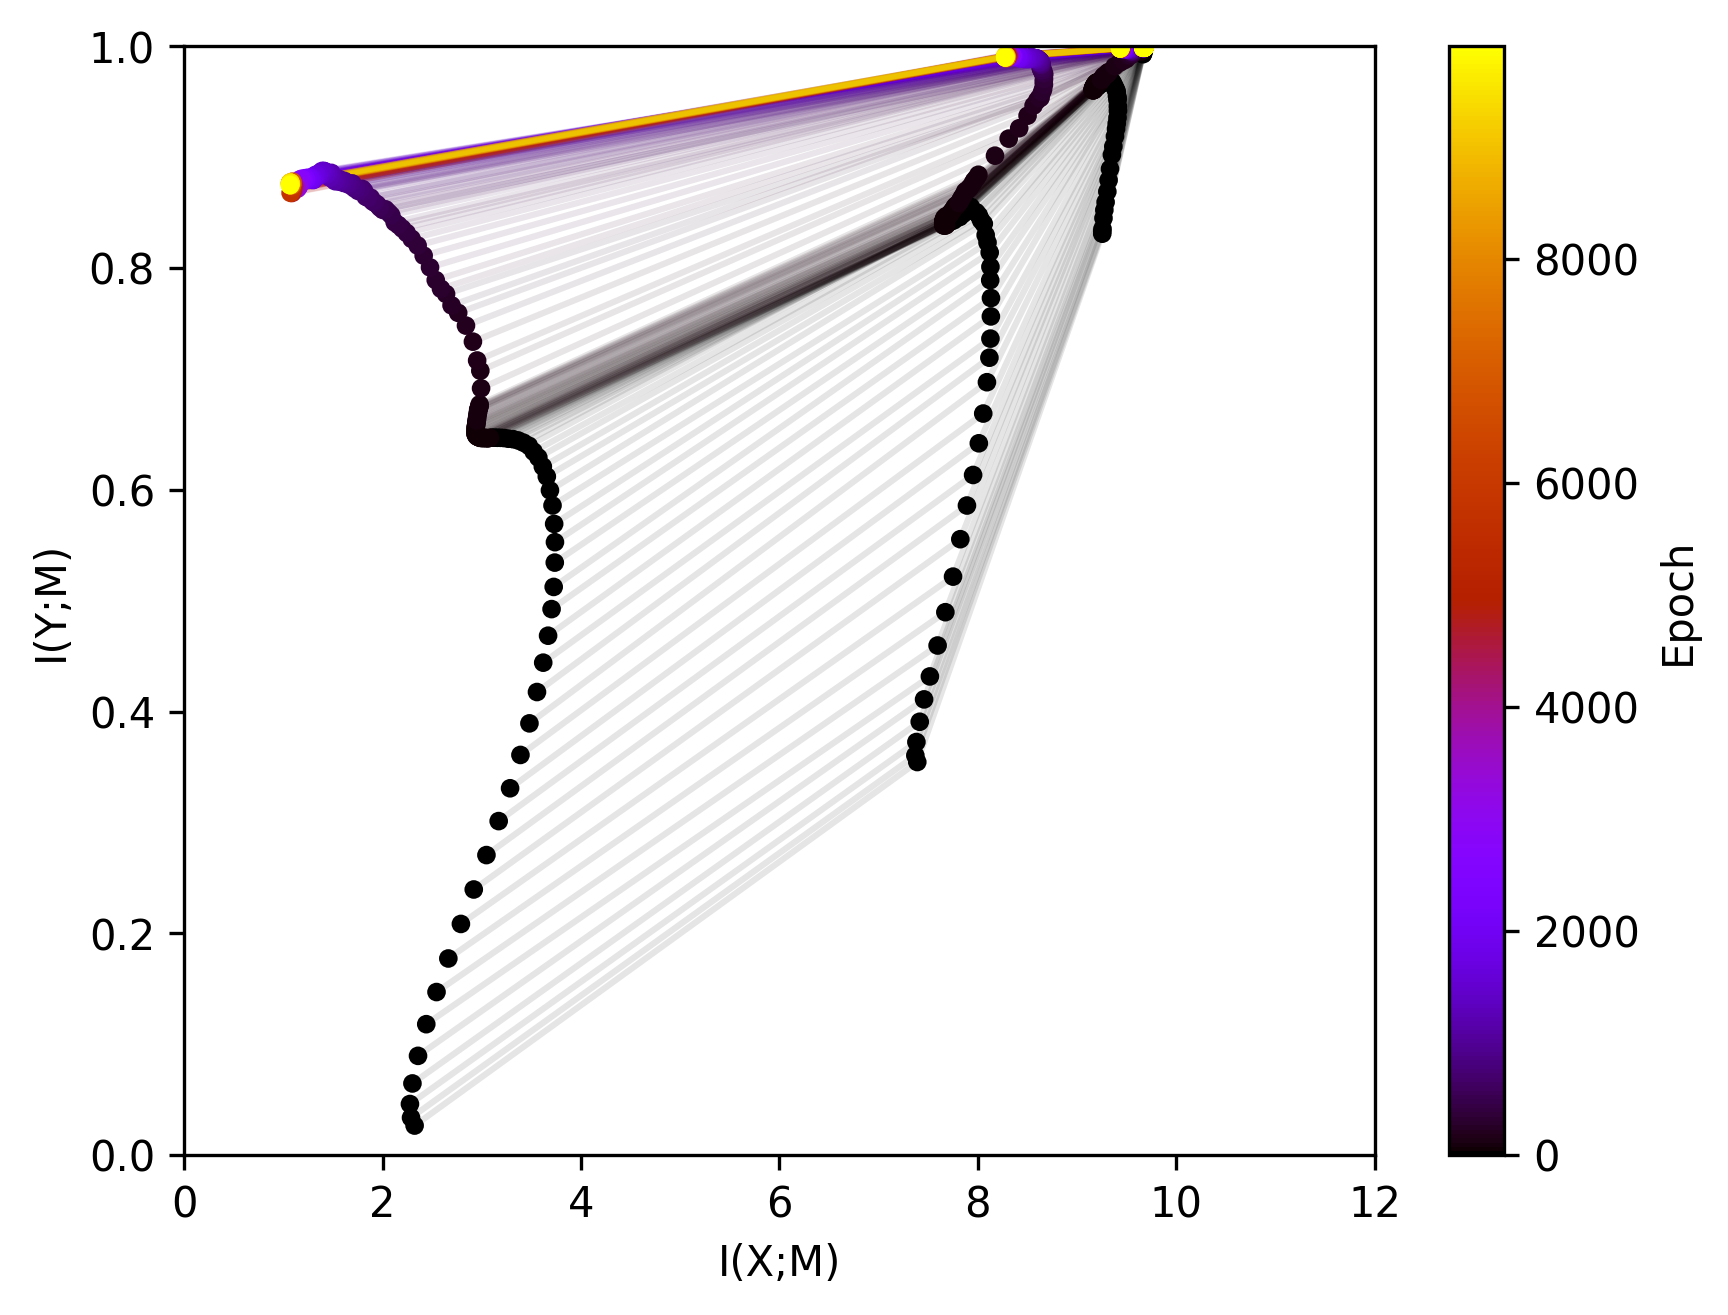

## activation function = relu, estimator = mi_estimator.edge

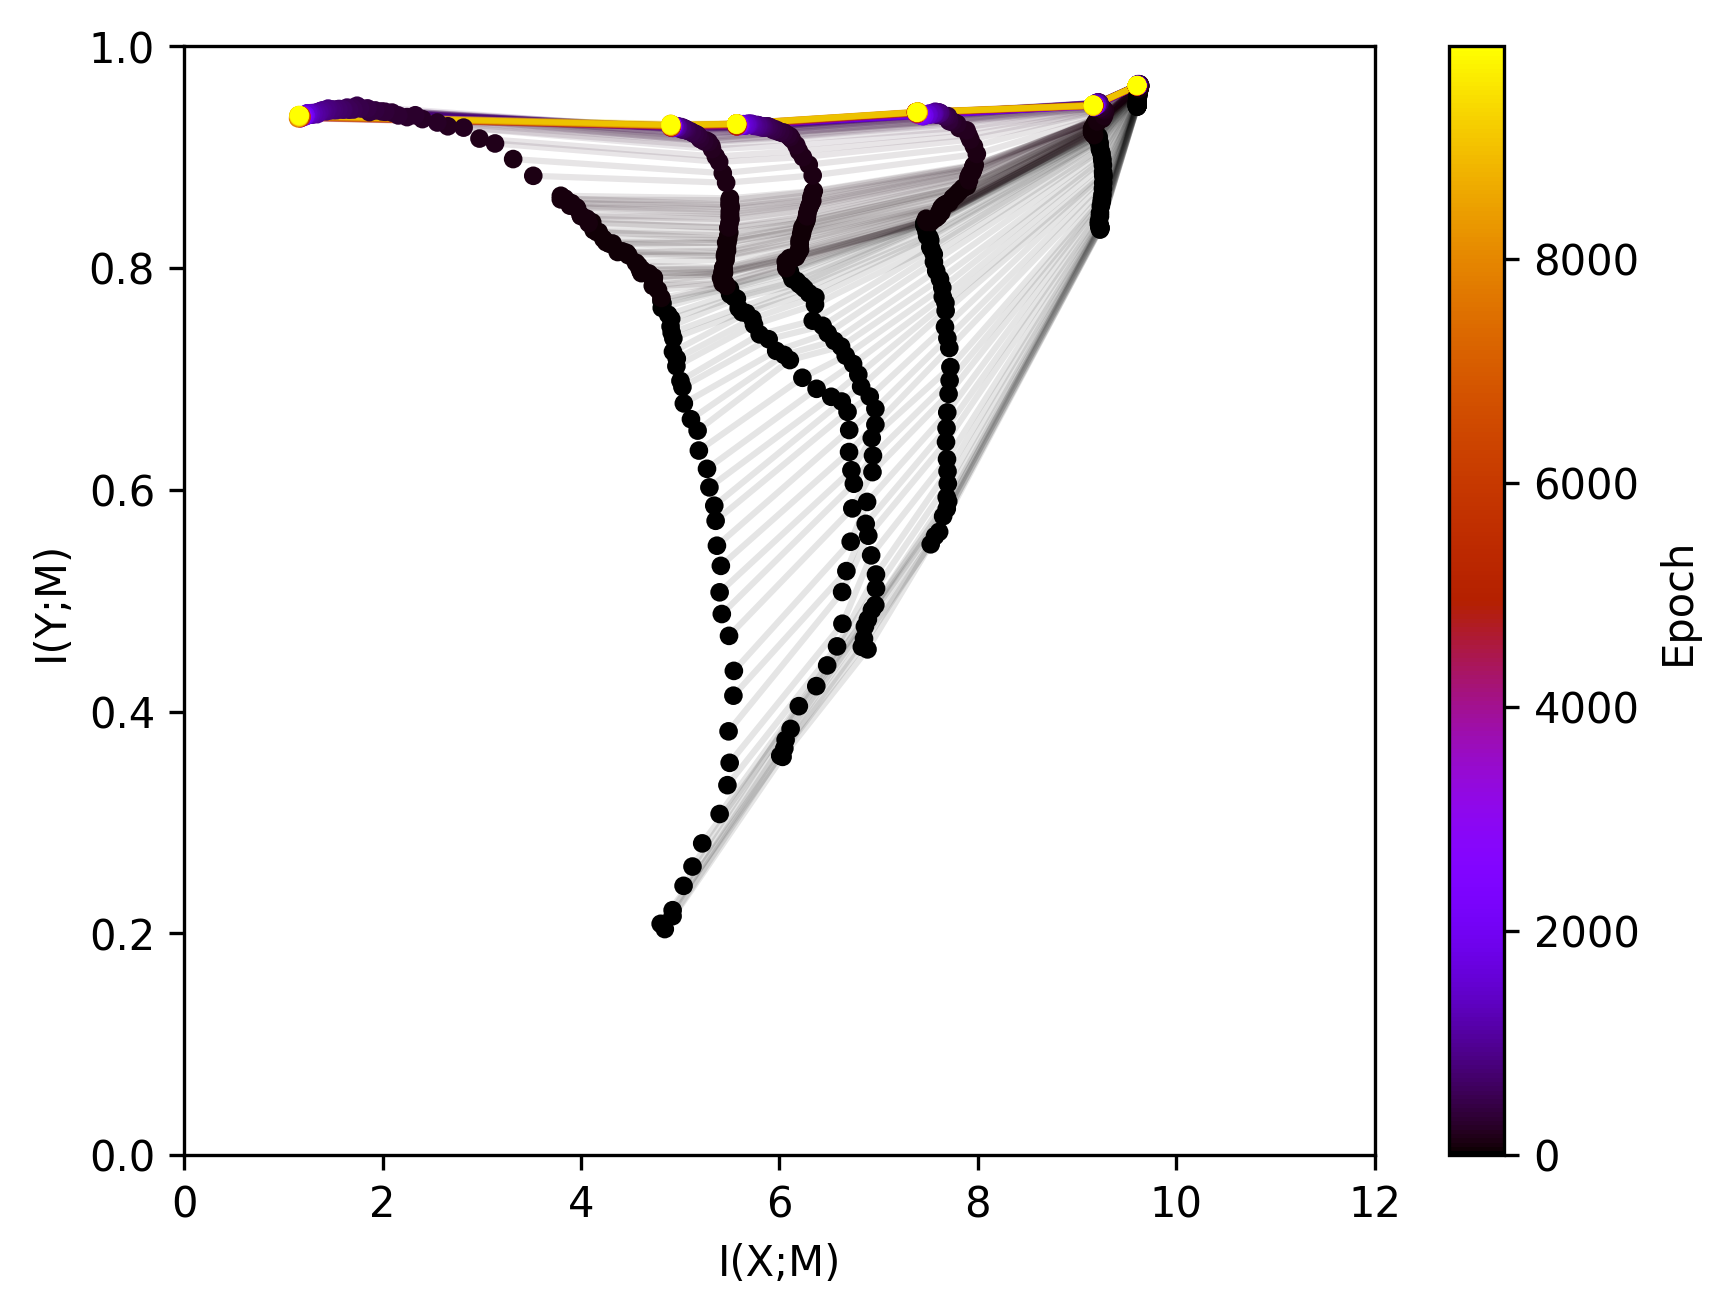

## activation function = relu, estimator = mi_estimator.upper

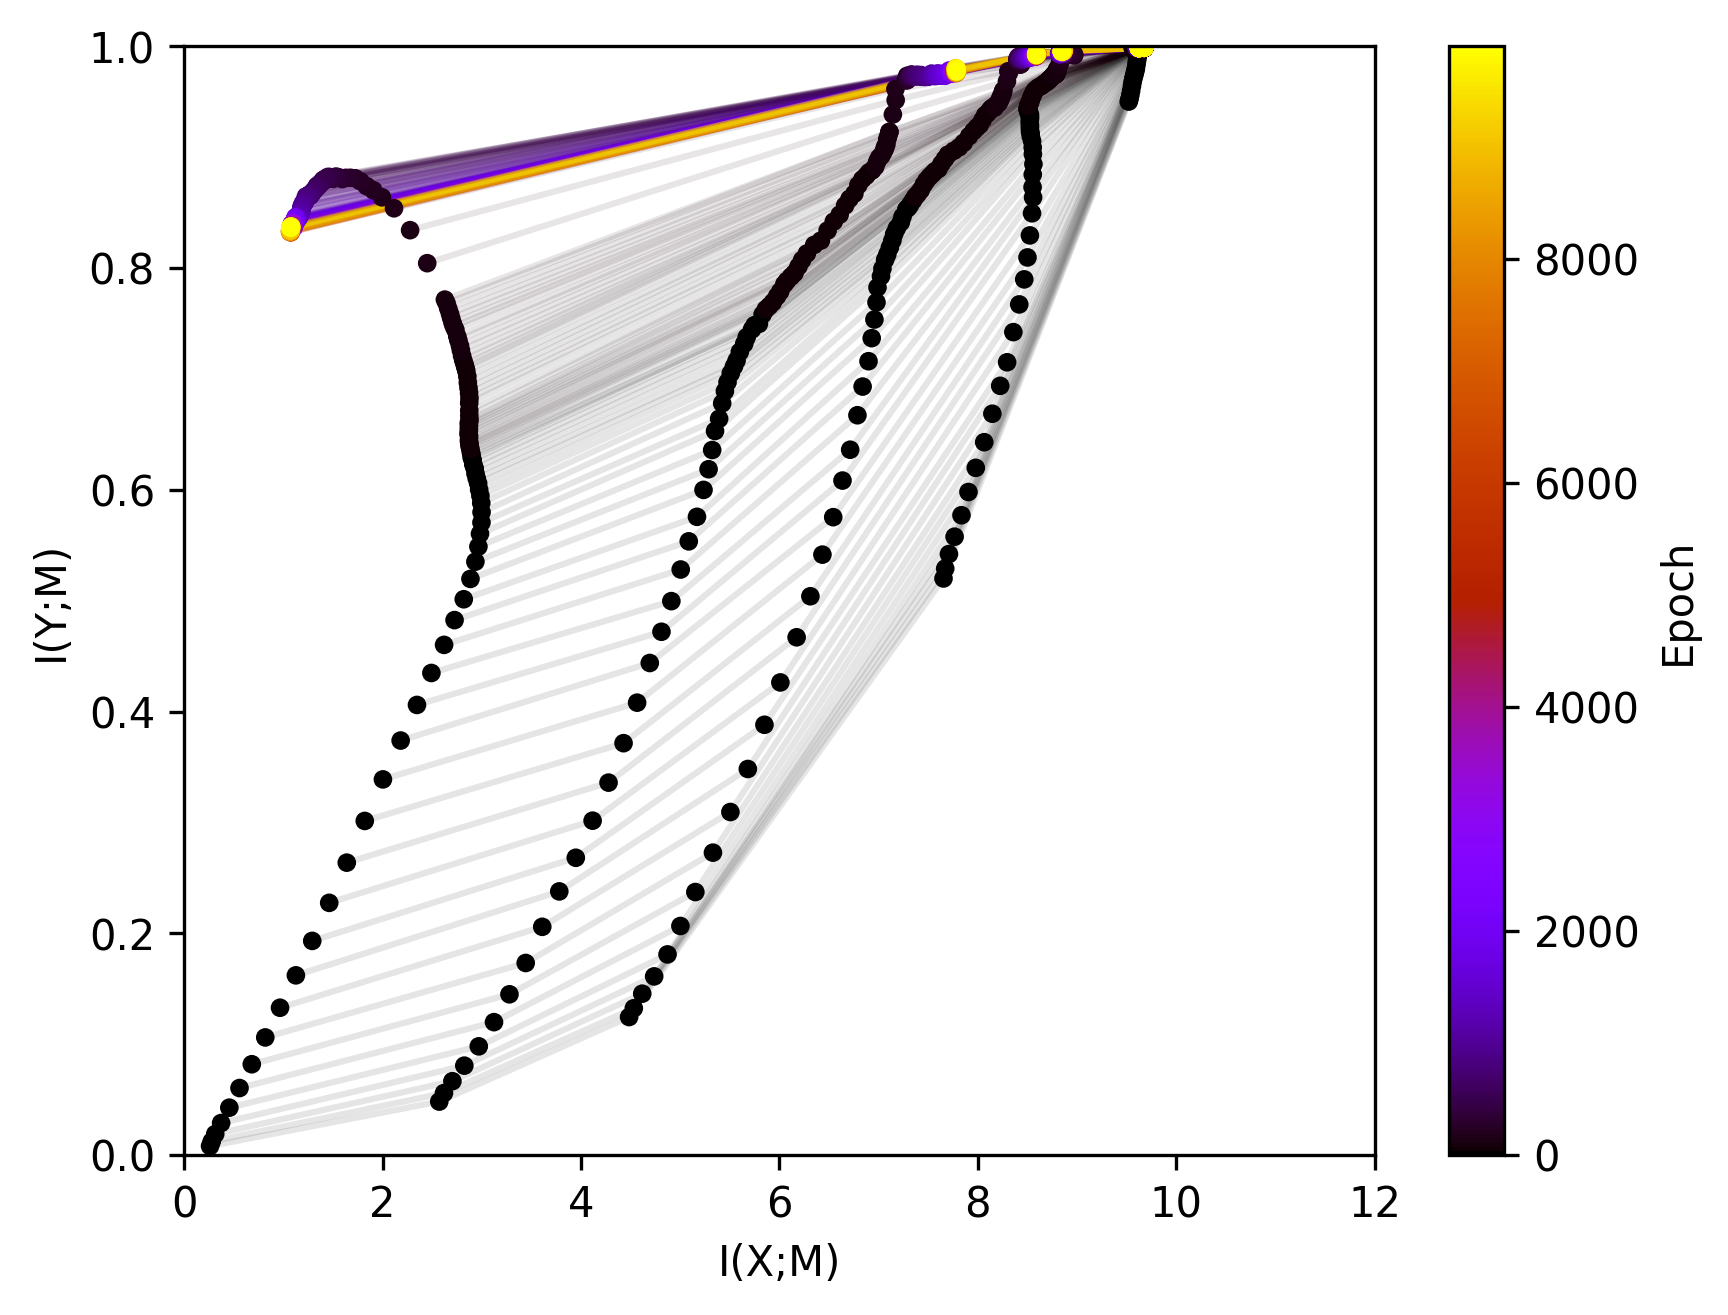

## activation function = tanh, estimator = mi_estimator.edge

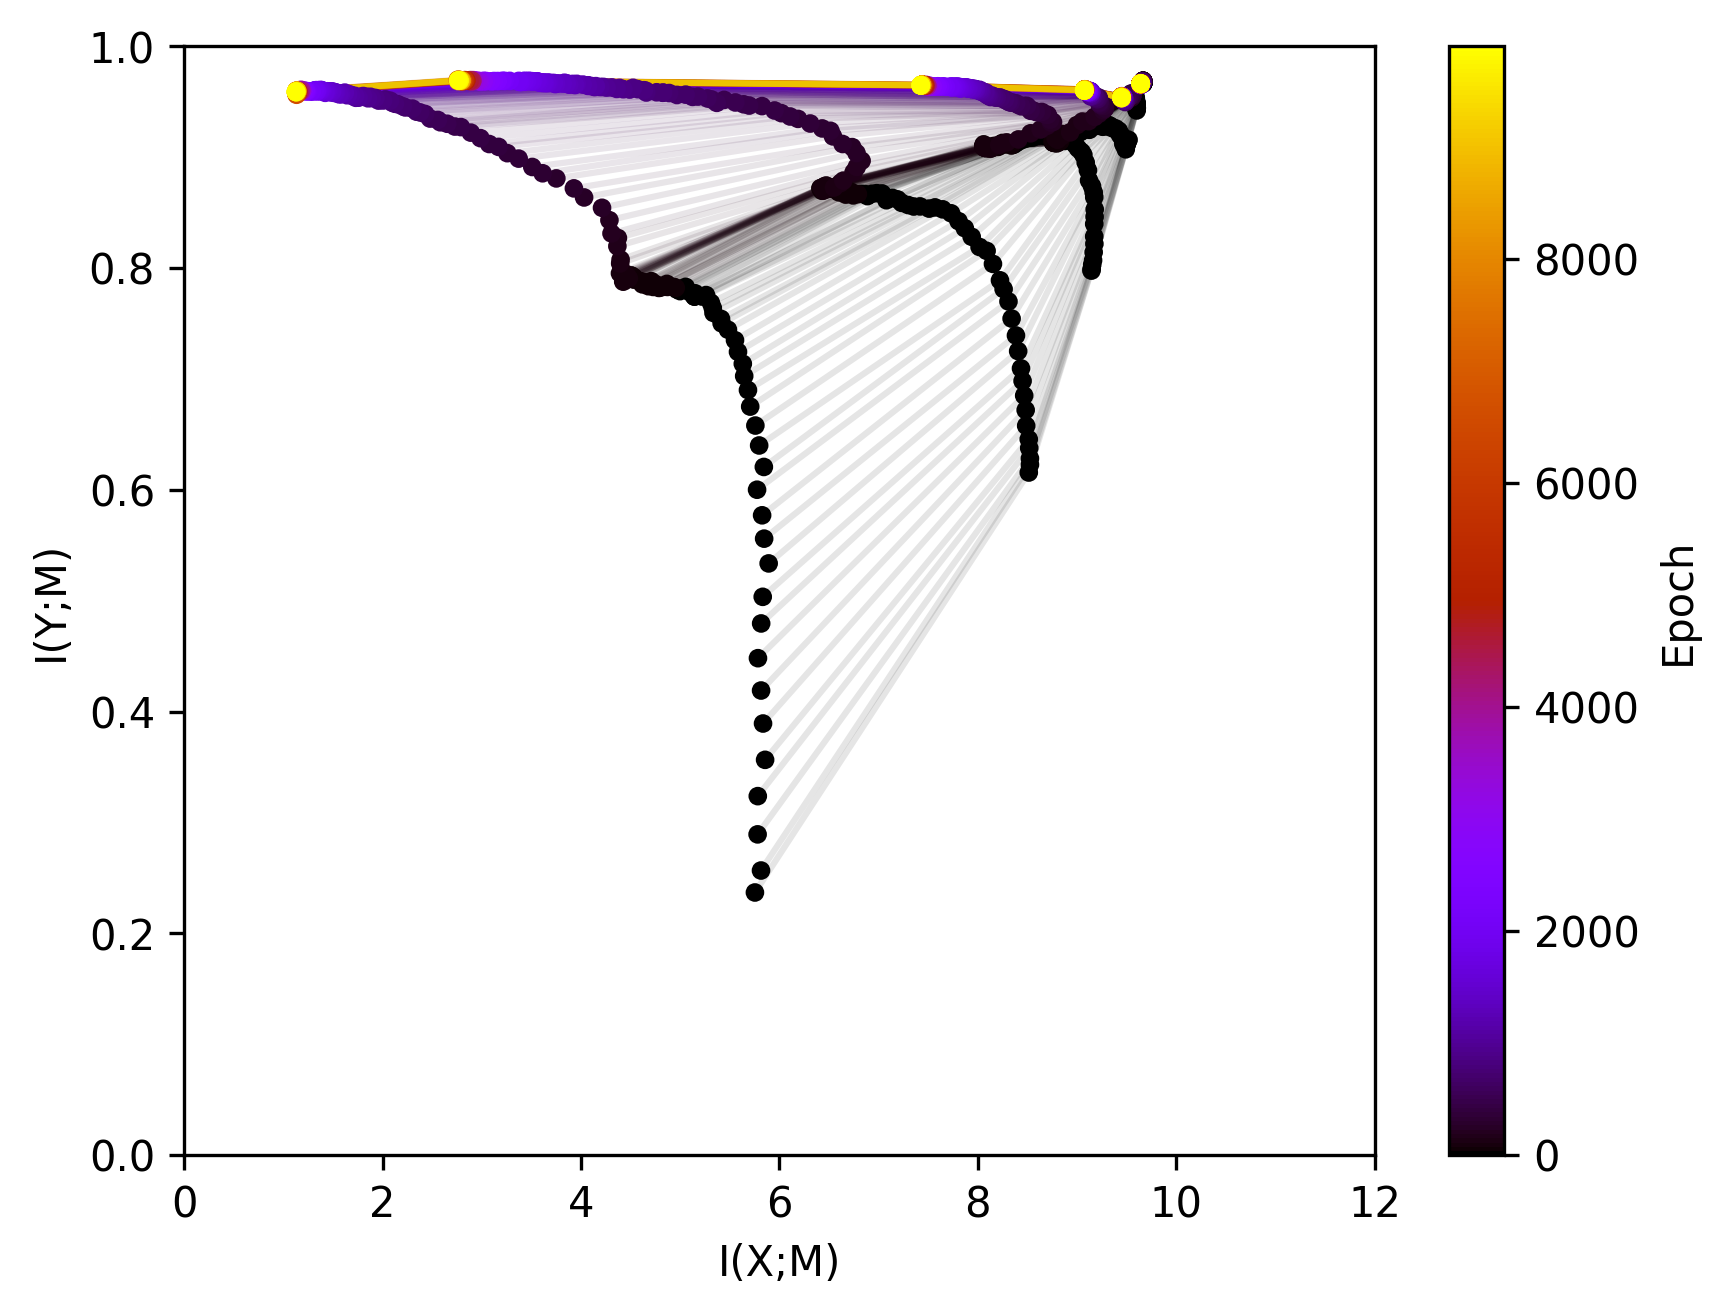

## activation function = elu, estimator = mi_estimator.edge

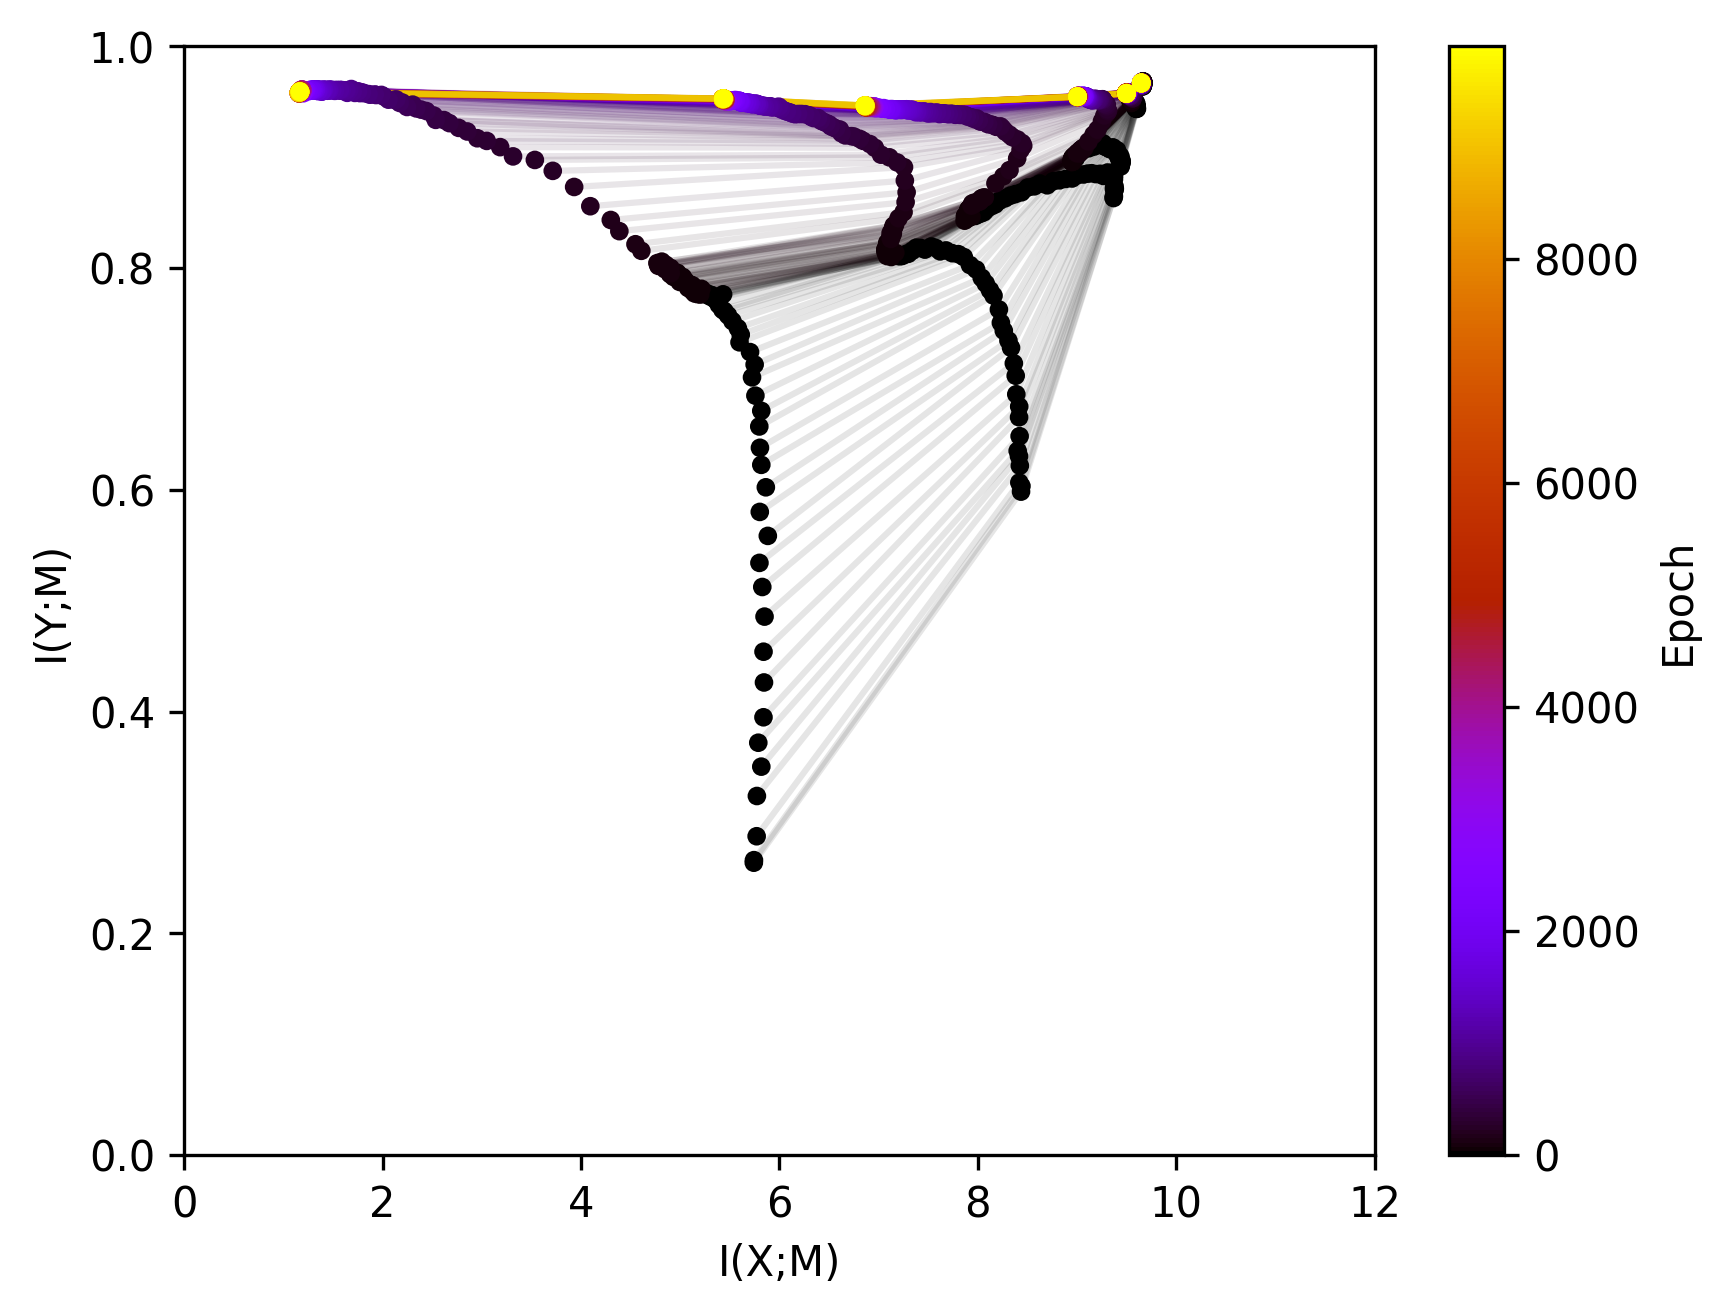

## activation function = elu, estimator = mi_estimator.edge

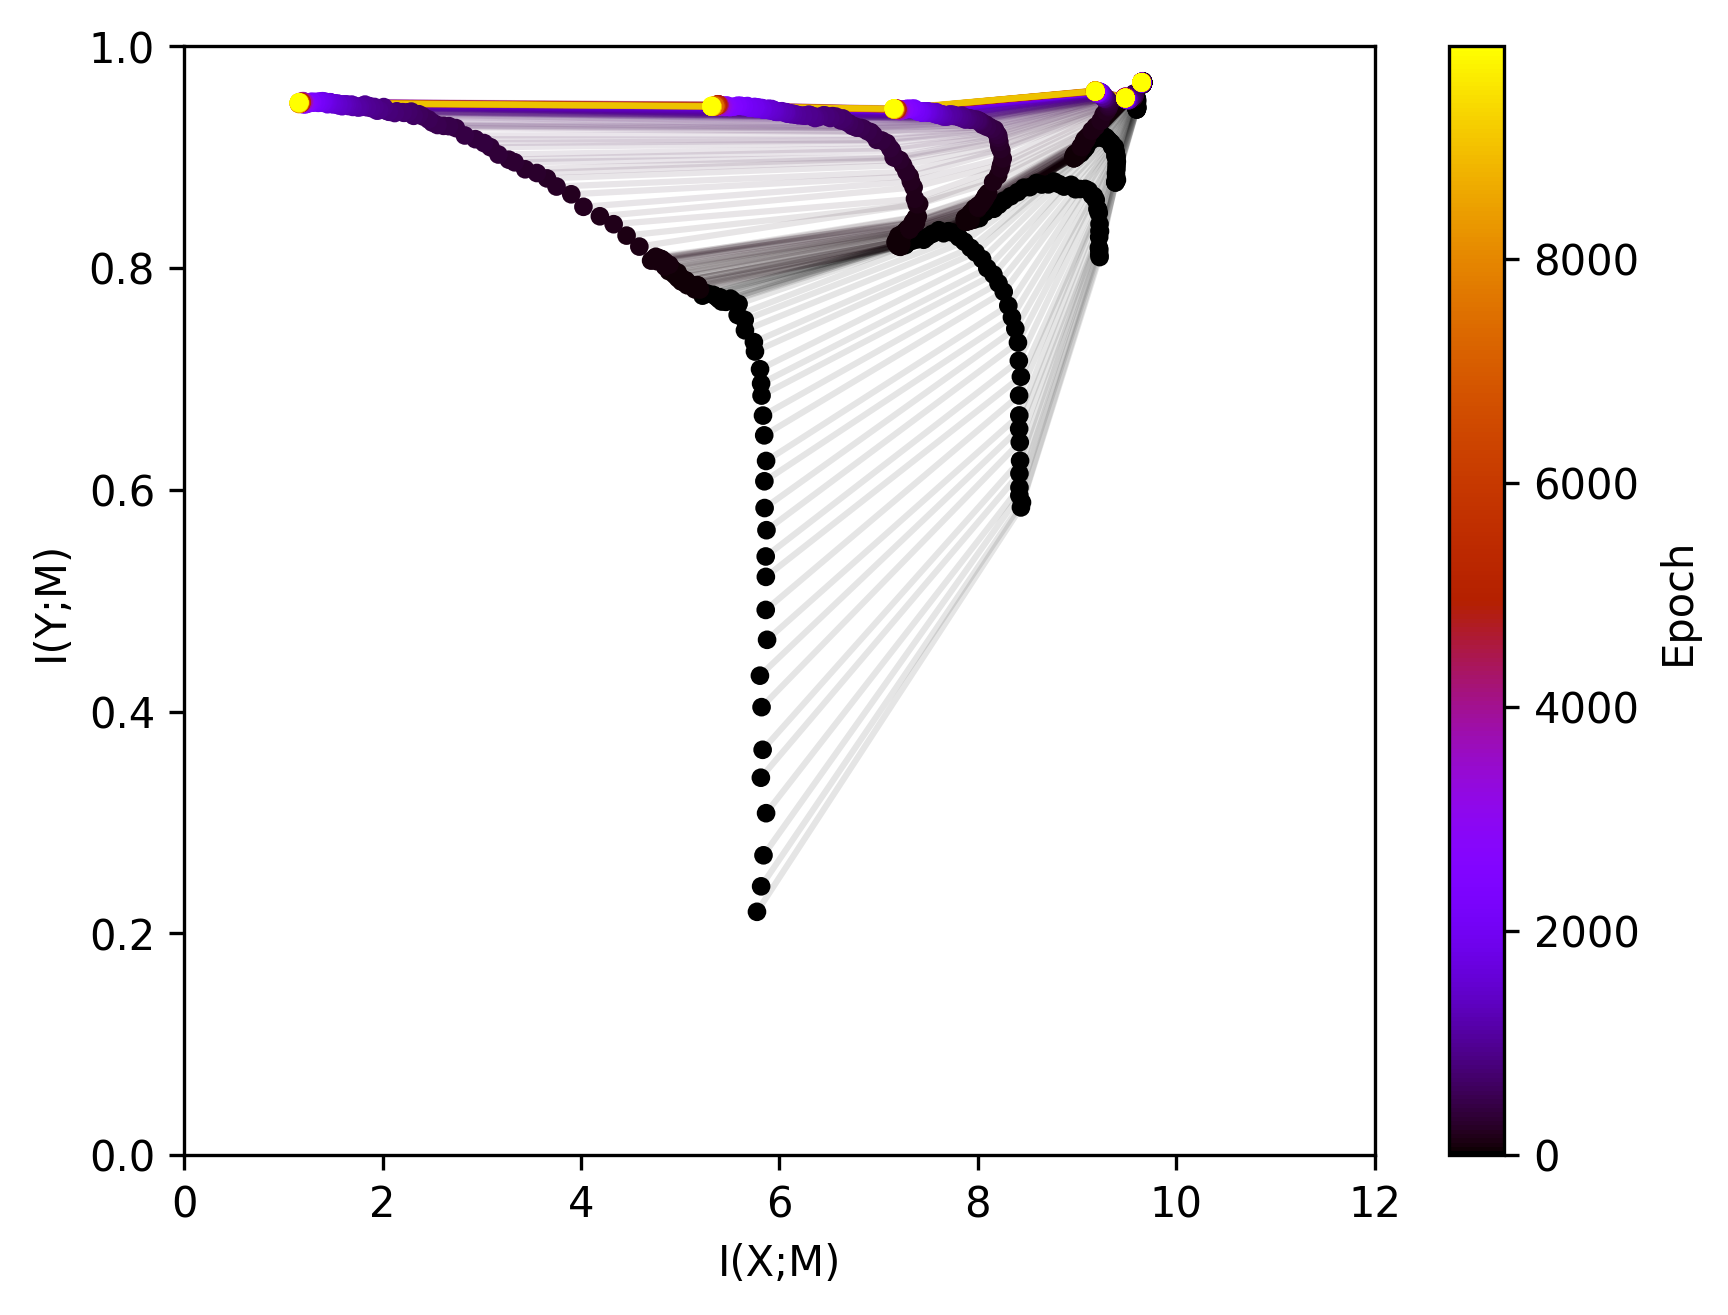

## activation function = elu, estimator = mi_estimator.binning

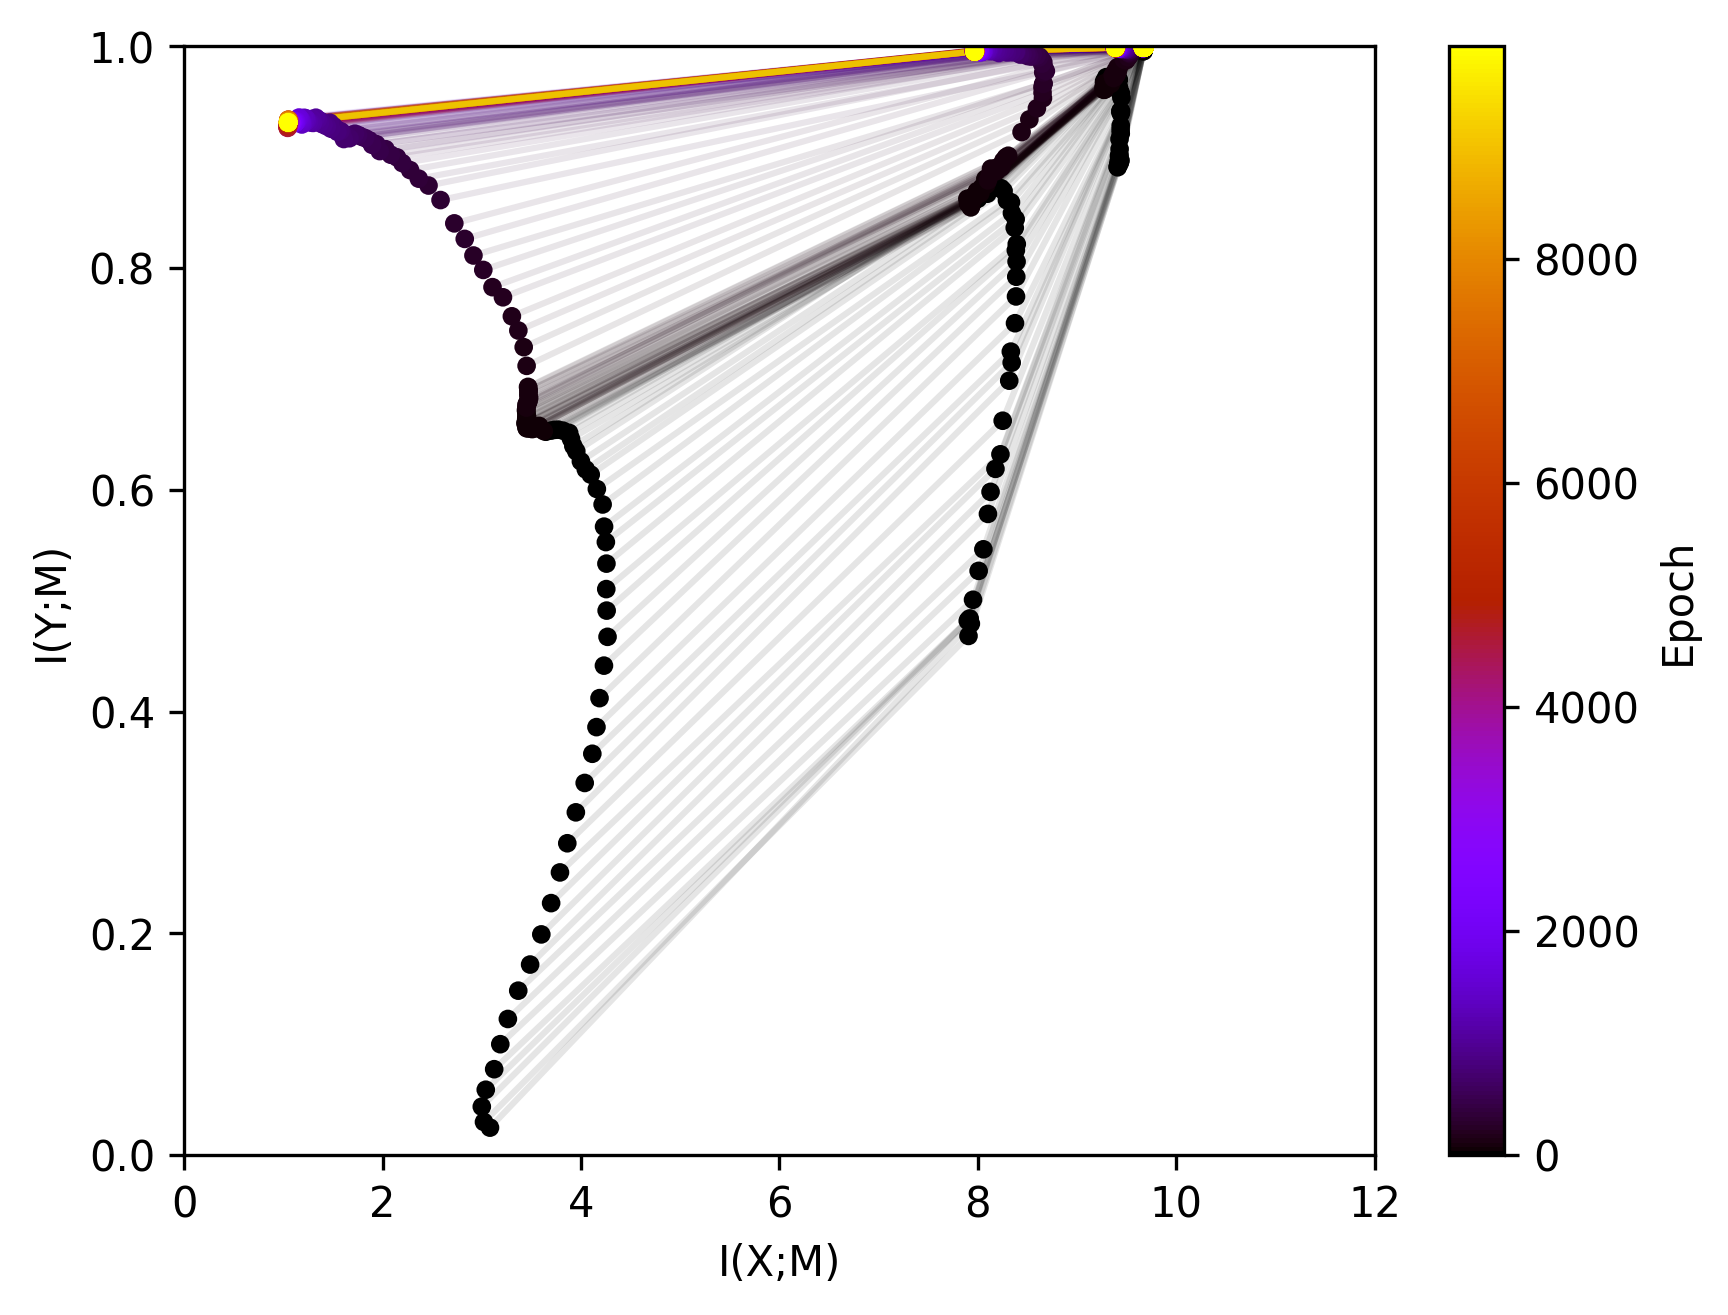

## activation function = tanh, estimator = mi_estimator.binning

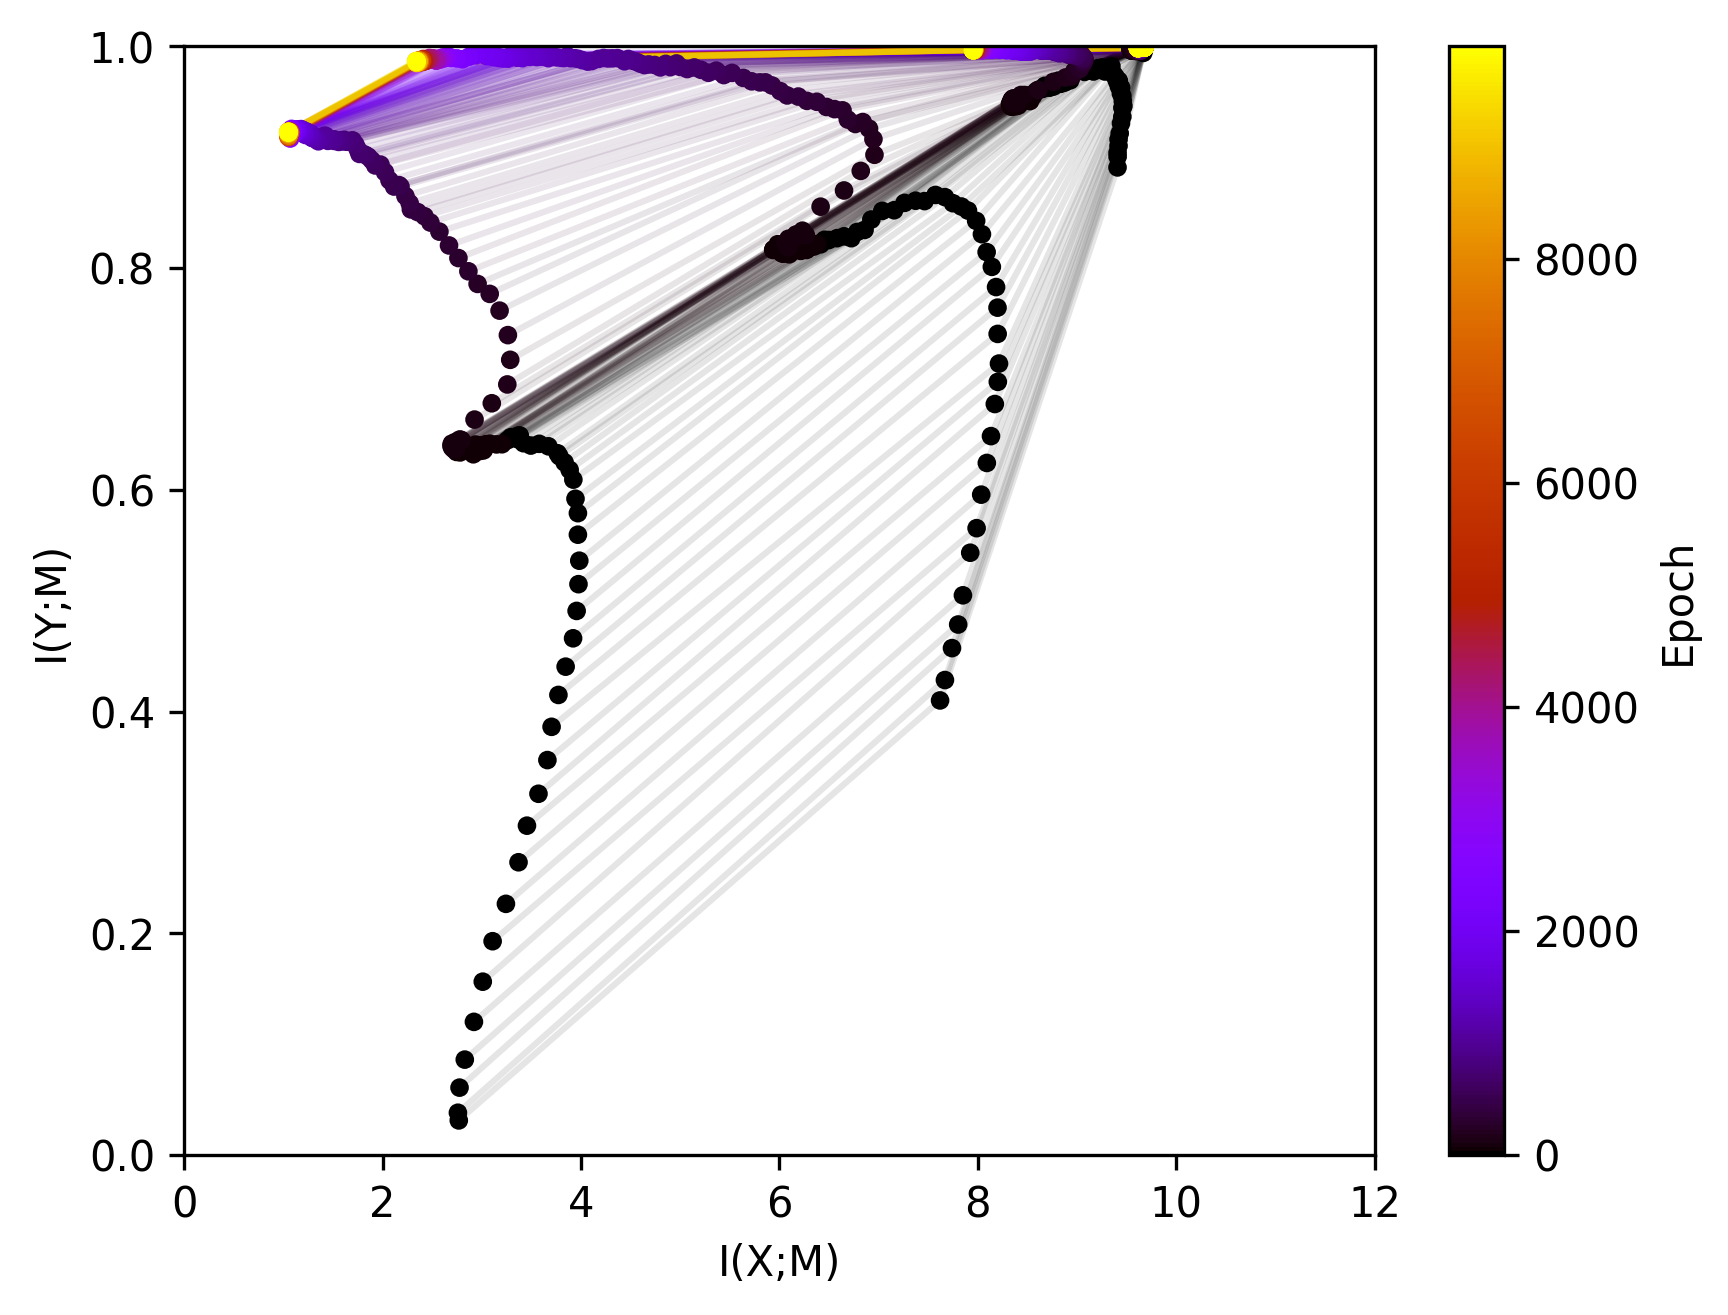

## activation function = tanh, estimator = mi_estimator.upper

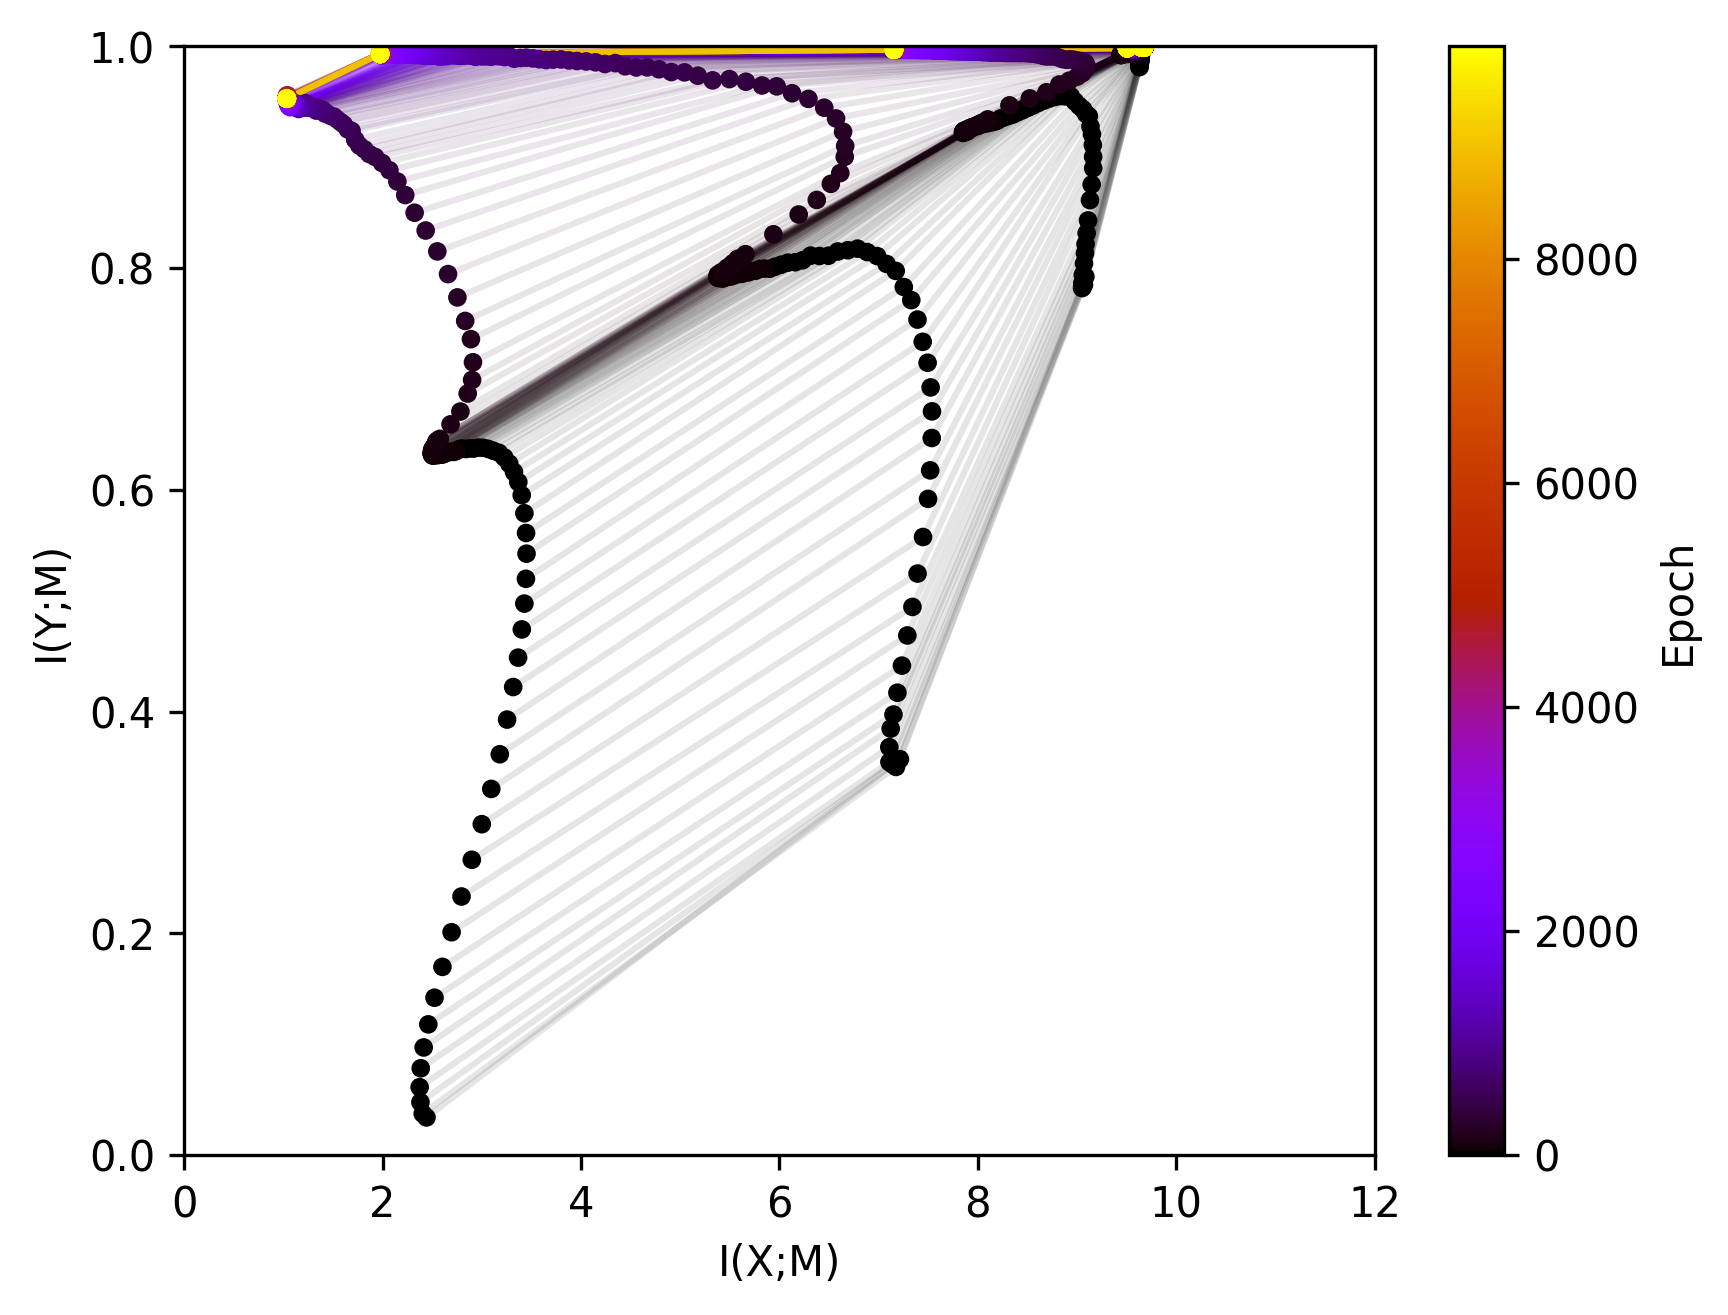

## activation function = tanh, estimator = mi_estimator.upper

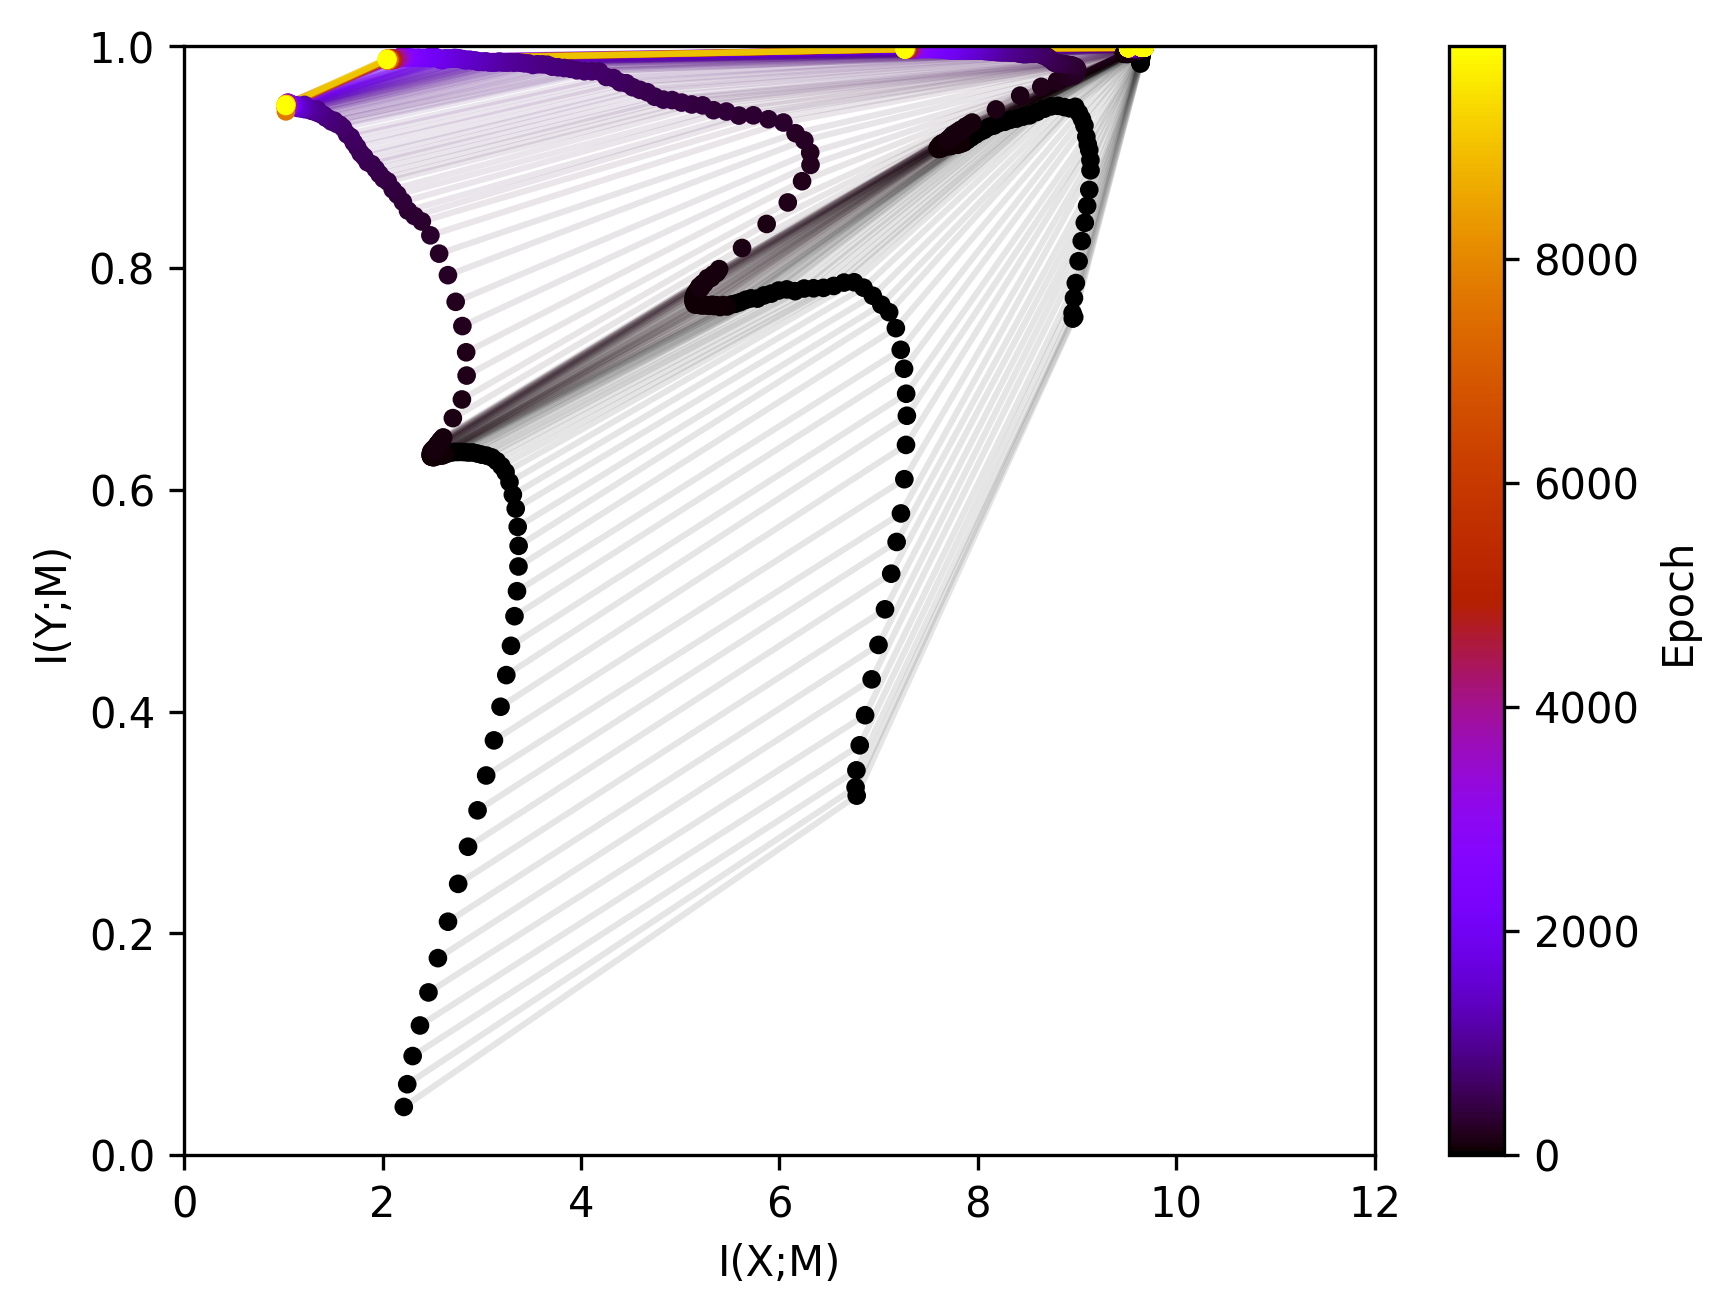

In [15]:
# for id_ in ids:
#     exp = loader.find_by_id(id_)
#     text = f"## activation function = {exp.config.activation_fn}, estimator = {exp.config.estimator}"
#     display.display(display.Markdown(text))
#     display.display(exp.artifacts["infoplane_test"].as_content_type("image/png").render())

In [11]:
measures_all_runs_test = exp.artifacts["information_measures_test.csv"].as_content_type("text/csv").render()
measures_all_runs_test

epoch  layer     MI_XM     MI_YM  run
0          0      0  9.677705  0.998802    0
1          0      1  9.677430  0.998774    0
2          0      2  9.654006  0.989532    0
3          0      3  8.605179  0.592560    0
4          0      4  5.665702  0.109257    0
...      ...    ...       ...       ...  ...
14995   9900      1  9.677712  0.998814    9
14996   9900      2  9.665556  0.998155    9
14997   9900      3  9.188104  0.962625    9
14998   9900      4  7.291998  0.886416    9
14999   9900      5  2.750693  0.778770    9

[15000 rows x 5 columns]

In [12]:
measures_summary = {}
measures_summary["mi_mean_over_runs"] = measures_all_runs_test.groupby(
            ["epoch", "layer"]
).mean()


In [21]:
exps = sorted([loader.find_by_id(id_) for id_ in ids], key=lambda exp: (exp.config.activation_fn, exp.config.estimator))
for exp in exps:
    print(exp.config.optimizer)

sgd
sgd
sgd
sgd
sgd
sgd
sgd
sgd
sgd


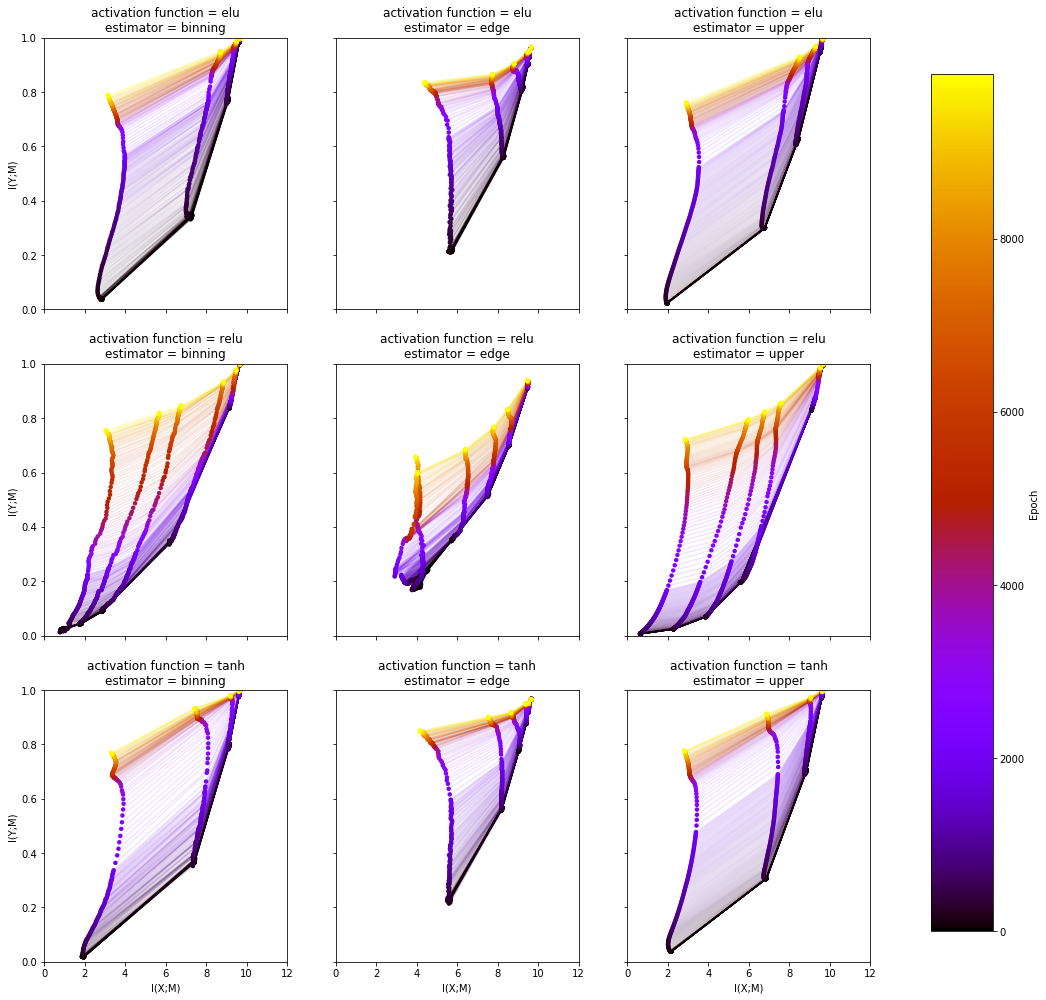

In [19]:
from math import ceil
from itertools import zip_longest


def plot_panel(ids, loader, information_measures_artifact_name: str):
    exps = sorted([loader.find_by_id(id_) for id_ in ids], key=lambda exp: (exp.config.activation_fn, exp.config.estimator))
    activation_functions = {exp.config.activation_fn for exp in exps}
    estimators = {exp.config.estimator for exp in exps}

    fig, axes = plt.subplots(nrows=len(activation_functions), ncols=len(estimators), sharex=True, sharey=True, figsize=(17, 17))
    for exp, ax in zip(exps, axes.flat):
        mi_measures = (
            exp.artifacts[information_measures_artifact_name]
            .as_content_type("text/csv")
            .render()
            .set_index(["epoch", "layer"])
            .groupby(["epoch", "layer"])
            .mean()
        )
        sm = infoplane_plot(mi_measures, ax)
        ax.set_title(f"activation function = {exp.config.activation_fn}\nestimator = {exp.config.estimator.split('.')[-1]}")
        
    for ax in axes[:, 0]:
        ax.set(ylabel='I(Y;M)')

    for ax in axes[-1, :]:
        ax.set(xlabel='I(X;M)')

    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

    fig.colorbar(sm, label='Epoch', cax=cbar_ax)
    #fig.tight_layout()

    return fig


def infoplane_plot(measures, ax):
    total_epochs = measures.index.get_level_values('epoch')[-1] + 1  # epoch index starts at 0
    sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=total_epochs))
    sm.set_array([])
    for epoch, mi_measures in measures.groupby(level=0):
        color = sm.to_rgba(epoch)

        xmvals = np.array(mi_measures['MI_XM'])
        ymvals = np.array(mi_measures['MI_YM'])

        ax.plot(xmvals, ymvals, color=color, alpha=0.1, zorder=1)
        ax.scatter(xmvals, ymvals, s=20, facecolors=color, edgecolor='none', zorder=2)
        ax.set(xlim=[0, 12], ylim=[0, 1])
    return sm


fig = plot_panel(ids, loader, "information_measures_test.csv");
fig.savefig("results_test.png")

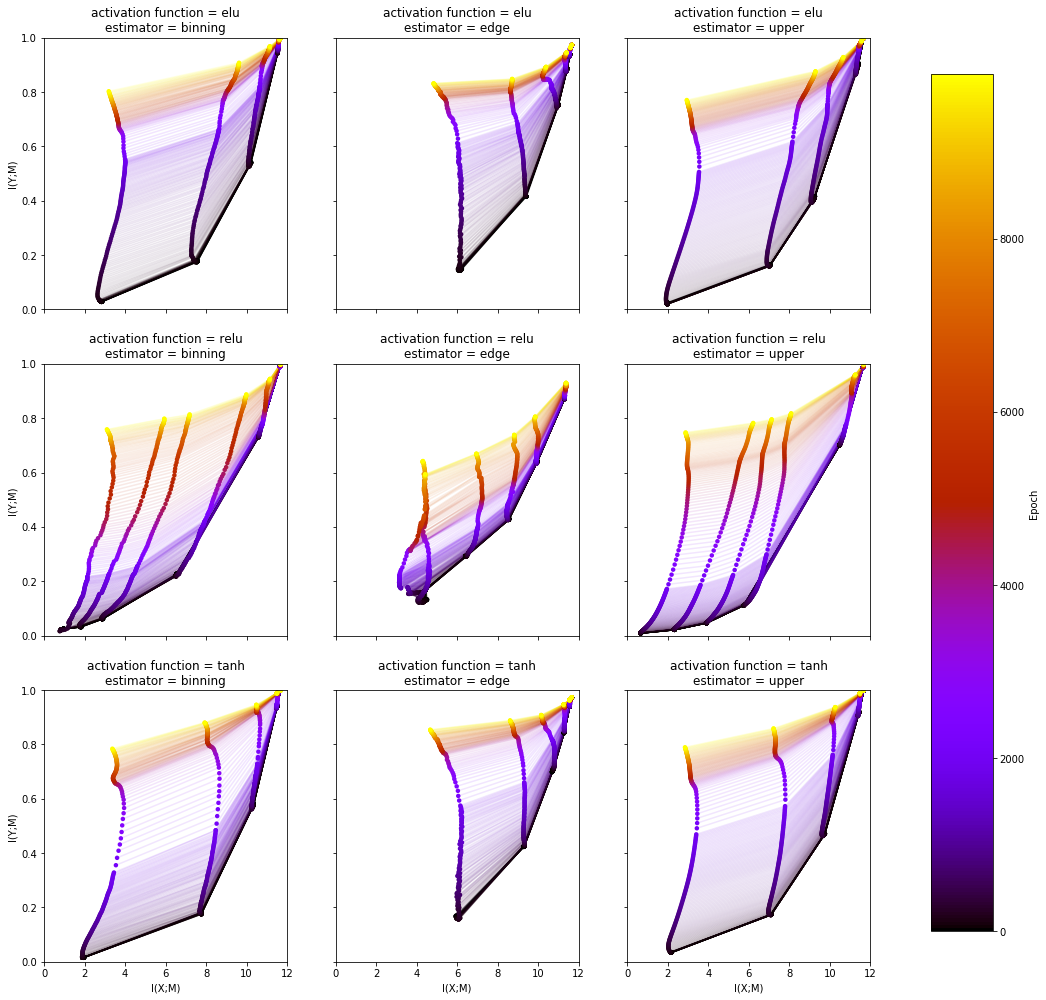

In [20]:
fig = plot_panel(ids, loader, "information_measures_train.csv");
fig.savefig("results_train.png")